# Modelling

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

import xgboost

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
#from tensorflow.nn import relu, softmax

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tensorflow.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    scaler_obj = StandardScaler()
    #scaler_obj = MinMaxScaler()
    scaler_obj.fit(x.values)
    x_scaled = scaler_obj.transform(x.values)
    #x_scaled = x.values
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map, scaler_obj)


def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map, scaler_obj = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map, scaler_obj)

## Read Data

In [3]:
remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'small_sema_slope', 'long_sema_slope']

In [4]:
file_name = 'tab_tick'
#file_name = 'full_tab_tick'

In [5]:
df = pd.read_csv('data/'+file_name+'_2019.csv')
df.drop(remove_cols, axis=1, inplace=True)
df.head(5)

,spread_avg,tick_sd,sema_diff,lema_diff,diff,avg_gain,avg_loss,rs,rsi,ssma_diff,lsma_diff,sma_diff,max_gap,min_gap,ema_diff,direction
0,0.000041,0.000004,-0.000044,-0.000015,-0.000009,0.000003,0.000042,0.070397,6.576755,-0.000043,-0.000003,-0.000107,0.000453,0.0,-0.000207,decrease
1,0.000047,0.000011,-0.000039,-0.000015,-0.000019,0.000003,0.000042,0.070583,6.592970,-0.000044,-0.000004,-0.000148,0.000472,0.0,-0.000231,decrease
2,0.000035,0.000023,-0.000043,-0.000016,-0.000048,0.000002,0.000045,0.051753,4.920611,-0.000052,-0.000004,-0.000195,0.000488,0.0,-0.000258,decrease
3,0.000041,0.000057,-0.000066,-0.000023,-0.000149,0.000002,0.000054,0.043435,4.162707,-0.000064,-0.000007,-0.000252,0.000569,0.0,-0.000301,decrease
4,0.000045,0.000024,-0.000079,-0.000028,-0.000130,0.000002,0.000058,0.040463,3.888955,-0.000070,-0.000010,-0.000312,0.000663,0.0,-0.000353,decrease


In [6]:
target_col = 'direction'
x_scaled, y_encoded, y_map, scaler_obj = data_prep(df, apply_smote = False)
joblib.dump(scaler_obj, 'data/model/scaler_obj.pkl') 
joblib.dump(y_map, 'data/model/y_map.pkl') 

Record count : 291806
--------------------------
increase    110987
decrease    109166
same         71653
Name: direction, dtype: int64
--------------------------
increase    0.380345
decrease    0.374105
same        0.245550
Name: direction, dtype: float64


['data/model/y_map.pkl']

In [7]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

## Random Forest

In [8]:
%%time
clf = RandomForestClassifier(n_jobs=-1) 
clf.fit(train_x, train_y)
joblib.dump(clf, 'data/model/model_rf.pkl') 

predictions = clf.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.64      0.91      0.75     21887
    increase       0.82      0.77      0.79     22017
        same       0.59      0.26      0.37     14458

    accuracy                           0.70     58362
   macro avg       0.68      0.65      0.64     58362
weighted avg       0.69      0.70      0.67     58362

Wall time: 23 s


Record count : 260430
--------------------------
decrease    110264
increase    109156
same         41010
Name: direction, dtype: int64
--------------------------
decrease    0.423392
increase    0.419138
same        0.157470
Name: direction, dtype: float64
              precision    recall  f1-score   support

    decrease       0.67      0.90      0.77    110264
    increase       0.87      0.71      0.78    109156
        same       0.42      0.24      0.31     41010

    accuracy                           0.72    260430
   macro avg       0.65      0.62      0.62    260430
weighted avg       0.72      0.72      0.70    260430



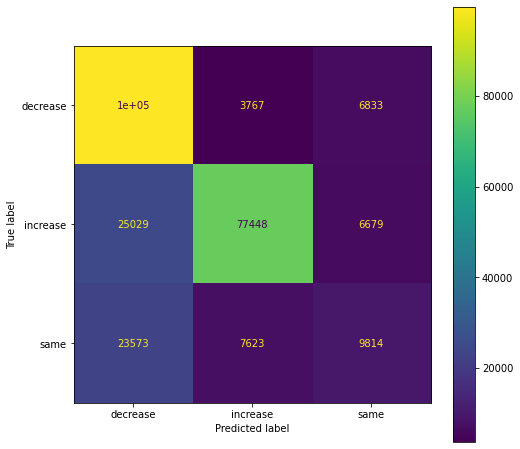

In [9]:
df1 = pd.read_csv('data/'+file_name+'_2018.csv')
df1.drop(remove_cols, axis=1, inplace=True)

x_scaled1, y_encoded1, y_map1, scaler_obj_1 = data_prep(df1, apply_smote = False)

clf_rf = joblib.load('data/model/model_rf.pkl') 
predictions = clf_rf.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
#df1.to_csv('data/'+file_name+'_2018_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(rounded_valid_y, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_map1.values())
disp.plot(ax=ax)

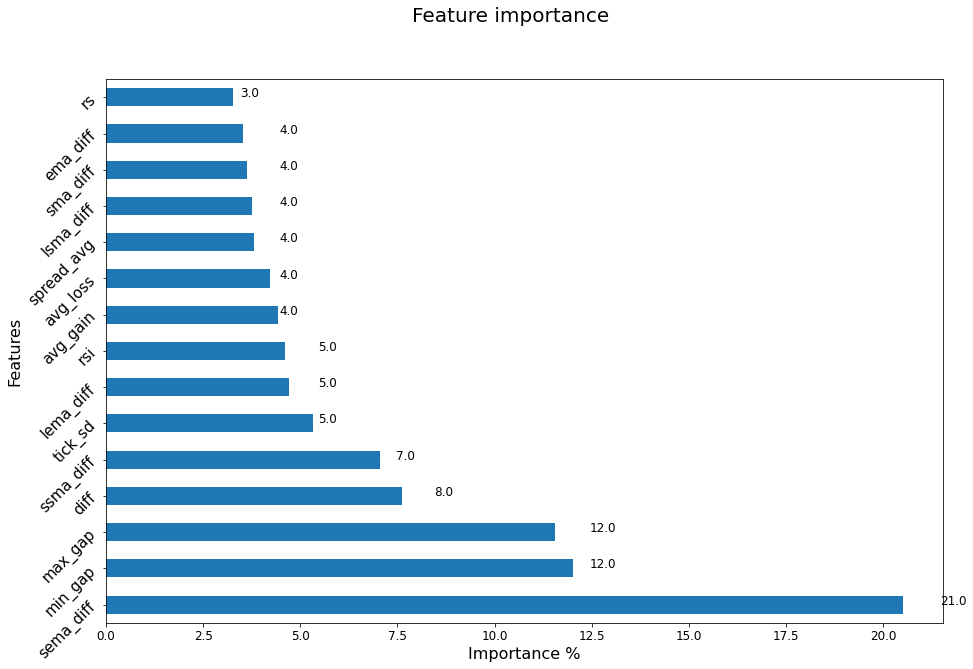

In [10]:
x_cols = df.columns[df.columns != 'direction']
fig = plt.figure()
fig.suptitle('Feature importance', fontsize=20)
plt.xlabel('Importance %', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)


feat_importances = pd.Series(clf_rf.feature_importances_ * 100, index=x_cols)
feat_importances.nlargest(30).plot(kind='barh', figsize=(15, 10), rot=45)

for index, value in enumerate(np.round(-np.sort(-clf.feature_importances_ * 100))):
    plt.text(value+0.45, index, str(value), fontsize=12)

live_df = pd.read_csv('data/live_preds.csv')
live_df.drop(remove_cols, axis=1, inplace=True)
del live_df['predicted_direction']

scaler_obj = joblib.load('data/model/scaler_obj.pkl')
y_map = joblib.load('data/model/y_map.pkl') 
x_scaled = scaler_obj.transform(live_df.values)

predictions = clf_rf.predict(x_scaled)

rounded_predictions = np.argmax(predictions, axis = -1)

live_df['predictions'] = [y_map[k] for k in rounded_predictions]

print(y_map)
live_df['predictions'].value_counts()

In [11]:
winsound.PlaySound('C:\\Windows\\Media\\tada.wav', winsound.SND_ASYNC)